In [1]:
from birdclef.utils import get_spark
import pyspark.sql.functions as F

In [2]:
spark = get_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/10 01:17:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [27]:
df = spark.read.parquet("../../data/processed/birdclef-2023/consolidated_v3_sample")
df.show(n=5)

+-------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+
|species|track_stem|track_type|          track_name|           embedding|      prediction_vec|         predictions|start_time|             energy|
+-------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+
|malkin1|  XC132986|  original|malkin1/XC132986.mp3|[0.75343722105026...|[-10.260432243347...|[{0, 2342, Phyllo...|        36|0.25369036197662354|
|refwar2|  XC128009|   source1|refwar2/XC128009_...|[0.19527475535869...|[-9.6245841979980...|[{0, 684, Cinclor...|        36| 20.364137649536133|
|malkin1|  XC132986|  original|malkin1/XC132986.mp3|[1.32953834533691...|[-13.427273750305...|[{0, 890, Culicic...|        69|0.18416672945022583|
|refwar2|  XC128009|  original|refwar2/XC128009.mp3|[1.89621150493621...|[-17.041515350341...|[{0, 185, Anthus ...|   

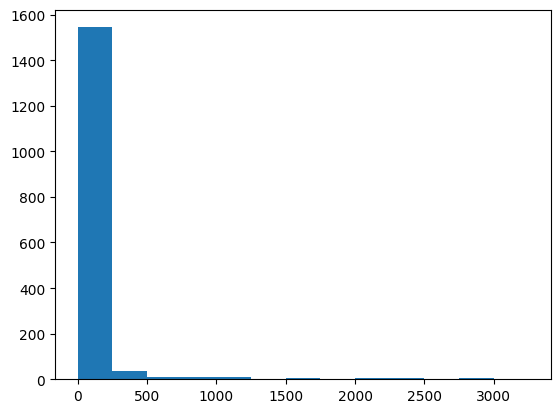

In [28]:
import matplotlib.pyplot as plt

energies = [x["energy"] for x in df.select("energy").collect()]

plt.hist(energies, bins=[250 * x for x in range(14)])
plt.show()

Exploded predictions

In [30]:
print(df.select(df.track_name).take(1)[0])

df.select(df.predictions).take(1)[0]["predictions"]

Row(track_name='malkin1/XC132986.mp3')


[Row(rank=0, index=2342, label='Phylloscopus trochiloides_Greenish Warbler', mapped_label='grewar3', probability=0.14227834343910217),
 Row(rank=1, index=1068, label='Ducula badia_Mountain Imperial-Pigeon', mapped_label='moipig1', probability=0.09622656553983688),
 Row(rank=2, index=1702, label='Macropygia ruficeps_Little Cuckoo-Dove', mapped_label='licdov1', probability=0.038490768522024155),
 Row(rank=3, index=359, label='Brachypteryx leucophris_Lesser Shortwing', mapped_label='lessho1', probability=0.018337246030569077),
 Row(rank=4, index=360, label='Brachypteryx montana_White-browed Shortwing', mapped_label='whbsho12', probability=0.006928994785994291),
 Row(rank=5, index=2335, label='Phylloscopus pulcher_Buff-barred Warbler', mapped_label='bubwar1', probability=0.005631797481328249),
 Row(rank=6, index=1588, label='Larvivora brunnea_Indian Blue Robin', mapped_label='inbrob1', probability=0.005230042617768049),
 Row(rank=7, index=890, label='Culicicapa ceylonensis_Gray-headed Cana

In [31]:
from pyspark.sql.functions import concat

explode_preds = df.select(
    "species",
    "track_stem",
    "track_name",
    "embedding",
    "start_time",
    "track_type",
    F.explode(df.predictions).alias("col"),
)
explode_preds = explode_preds.select(
    concat(
        explode_preds.track_name, explode_preds.start_time, explode_preds.track_type
    ).alias("track_id"),
    "track_name",
    "species",
    "embedding",
    explode_preds.col.label.alias("label"),
    explode_preds.col.mapped_label.alias("mapped_label"),
    explode_preds.col.probability.alias("probability"),
)
explode_preds.show()

+--------------------+--------------------+-------+--------------------+--------------------+------------+--------------------+
|            track_id|          track_name|species|           embedding|               label|mapped_label|         probability|
+--------------------+--------------------+-------+--------------------+--------------------+------------+--------------------+
|malkin1/XC132986....|malkin1/XC132986.mp3|malkin1|[0.75343722105026...|Phylloscopus troc...|     grewar3| 0.14227834343910217|
|malkin1/XC132986....|malkin1/XC132986.mp3|malkin1|[0.75343722105026...|Ducula badia_Moun...|     moipig1| 0.09622656553983688|
|malkin1/XC132986....|malkin1/XC132986.mp3|malkin1|[0.75343722105026...|Macropygia rufice...|     licdov1|0.038490768522024155|
|malkin1/XC132986....|malkin1/XC132986.mp3|malkin1|[0.75343722105026...|Brachypteryx leuc...|     lessho1|0.018337246030569077|
|malkin1/XC132986....|malkin1/XC132986.mp3|malkin1|[0.75343722105026...|Brachypteryx mont...|    whbsho1

Visualizing Distribution of Probability

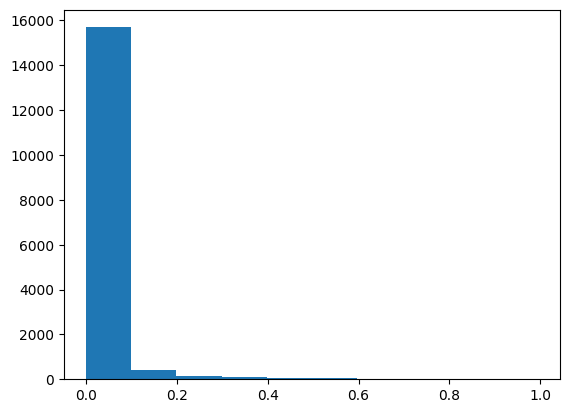

In [50]:
import matplotlib.pyplot as plt

probs_no_sig = [x["probability"] for x in explode_preds.select("probability").collect()]
plt.hist(probs_no_sig)
plt.show()

Taking rows with prob > 0.5

In [33]:
explode_preds_bird_calls = explode_preds.filter(explode_preds.probability > 0.5)
explode_preds_bird_calls.show()
print(explode_preds_bird_calls.count())

+--------------------+--------------------+-------+--------------------+--------------------+------------+------------------+
|            track_id|          track_name|species|           embedding|               label|mapped_label|       probability|
+--------------------+--------------------+-------+--------------------+--------------------+------------+------------------+
|refwar2/XC596322_...|refwar2/XC596322_...|refwar2|[0.99149847030639...|Human vocal_Human...|      humvoc|0.6938544511795044|
|refwar2/XC525931_...|refwar2/XC525931_...|refwar2|[1.43871796131134...|Prinia sylvatica_...|     junpri1|0.8636960387229919|
|malkin1/XC369825_...|malkin1/XC369825_...|malkin1|[1.16651332378387...|Limnothlypis swai...|      swawar|0.5569329857826233|
|malkin1/XC574560....|malkin1/XC574560.mp3|malkin1|[1.23353230953216...|Cinnyris jugulari...|     olbsun4|0.6094335913658142|
|malkin1/XC132991....|malkin1/XC132991.mp3|malkin1|[1.14792478084564...|Phylloscopus orie...|     eabwar1|0.5228896737

parsing species name

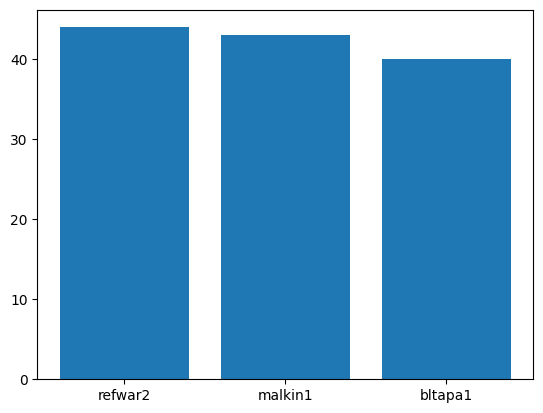

In [34]:
species = [s["species"] for s in explode_preds_bird_calls.select("species").collect()]
species_count = dict()
for s in species:
    species_count[s] = species_count.get(s, 0) + 1
plt.bar(list(species_count.keys()), list(species_count.values()))
plt.show()

final dataset

In [35]:
from pyspark.sql.functions import rand

length = len(explode_preds_bird_calls.select("embedding").take(1)[0]["embedding"])

explode_preds_bird_calls = explode_preds_bird_calls.drop("probability")
explode_preds_bird_calls = explode_preds_bird_calls.dropDuplicates(["track_id"])
data = explode_preds_bird_calls.select(
    ["track_id", "species"]
    + [
        explode_preds_bird_calls.embedding[i].alias("embedding" + str(i))
        for i in range(length)
    ]
)
data = data.orderBy(rand())
data = data.toPandas()
print(len(data))
data.head()

121


,track_id,species,embedding0,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6,embedding7,...,embedding310,embedding311,embedding312,embedding313,embedding314,embedding315,embedding316,embedding317,embedding318,embedding319
0,bltapa1/XC289706_source3.mp33source3,bltapa1,0.747837,0.826928,0.920046,0.107157,0.802774,0.766423,1.526463,0.315954,...,0.767657,0.458525,0.785656,1.492056,0.392541,0.196696,0.636081,0.831117,0.717517,1.051443
1,malkin1/XC515910_source0.mp321source0,malkin1,1.475721,1.143599,0.831729,0.853280,1.068583,1.012339,0.675018,0.666281,...,1.713068,0.863107,0.731349,1.507534,0.610455,0.909536,1.500529,0.346067,0.712522,0.561404
2,malkin1/XC515910.mp336original,malkin1,1.250038,1.441285,0.517047,0.769446,0.914989,0.045104,0.266528,0.394065,...,1.806681,1.303210,0.659017,0.718031,0.155429,1.212442,1.867978,0.354417,0.955492,0.199649
3,bltapa1/XC552197_source0.mp33source0,bltapa1,1.419320,0.722742,0.402076,1.055211,1.733959,1.353318,0.533325,0.926222,...,0.768342,0.430095,0.721536,0.925512,0.698033,0.756105,0.460456,0.540027,1.388826,0.880988
4,refwar2/XC596322_source3.mp30source3,refwar2,0.413504,1.714097,0.999521,0.749864,0.641617,1.168537,0.789732,1.023274,...,0.497542,0.742261,1.179353,1.255932,0.658759,0.704522,0.557756,0.934936,0.510510,1.085886


base classifiers

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_x, test_x, train_y, test_y = train_test_split(
    data.loc[:, (data.columns != "species") & (data.columns != "track_id")],
    data["species"],
    test_size=0.25,
    stratify=sorted(data["species"]),
)


def eval(truth, preds):
    print("Accuracy:", accuracy_score(truth, preds))
    print(
        "Precision:",
        precision_score(truth, preds, average=None),
        precision_score(truth, preds, average="macro"),
    )
    print(
        "Recall:",
        recall_score(truth, preds, average=None),
        recall_score(truth, preds, average="macro"),
    )
    print(
        "F1 Score:",
        f1_score(truth, preds, average=None),
        f1_score(truth, preds, average="macro"),
    )

In [13]:
from sklearn.tree import DecisionTreeClassifier

treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(train_x, train_y)
preds = treeClassifier.predict(test_x)

eval(test_y, preds)

Accuracy: 0.7741935483870968
Precision: [0.8        0.77777778 0.75      ] 0.775925925925926
Recall: [0.88888889 0.7        0.75      ] 0.7796296296296296
F1 Score: [0.84210526 0.73684211 0.75      ] 0.7763157894736842


In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)
preds = knn.predict(test_x)

eval(test_y, preds)

Accuracy: 0.967741935483871
Precision: [0.9 1.  1. ] 0.9666666666666667
Recall: [1.  0.9 1. ] 0.9666666666666667
F1 Score: [0.94736842 0.94736842 1.        ] 0.9649122807017544


In [15]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=1000)
log.fit(train_x, train_y)
preds = log.predict(test_x)

eval(test_y, preds)

Accuracy: 0.967741935483871
Precision: [1.         1.         0.92307692] 0.9743589743589745
Recall: [1.  0.9 1. ] 0.9666666666666667
F1 Score: [1.         0.94736842 0.96      ] 0.9691228070175439


In [16]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_y)

xgbc = XGBClassifier()
xgbc.fit(train_x, le.transform(train_y))
preds = xgbc.predict(test_x)

eval(le.transform(test_y), preds)

Accuracy: 0.8064516129032258
Precision: [0.88888889 0.8        0.75      ] 0.812962962962963
Recall: [0.88888889 0.8        0.75      ] 0.812962962962963
F1 Score: [0.88888889 0.8        0.75      ] 0.812962962962963


In [18]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [25 * i for i in range(1, 10)],
}

search = GridSearchCV(
    estimator=xgbc, param_grid=params, scoring="precision_macro", n_jobs=-1, cv=2
)
search.fit(train_x, le.transform(train_y))
print(search.best_params_)
preds = search.predict(test_x)

eval(le.transform(test_y), preds)

{'n_estimators': 25}
Accuracy: 0.8387096774193549
Precision: [0.88888889 0.76923077 0.88888889] 0.849002849002849
Recall: [0.8        0.90909091 0.8       ] 0.8363636363636363
F1 Score: [0.84210526 0.83333333 0.84210526] 0.8391812865497076


Saving models to disk

In [20]:
import pickle

pickle.dump(
    log, open("../../data/models/baseline/logistic_reg_2.pkl", "wb"), protocol=2
)
pickle.dump(
    log, open("../../data/models/baseline/logistic_reg_3.pkl", "wb"), protocol=3
)

Generating submission.csv

In [49]:
import pandas as pd

results = log.predict_proba(test_x)
species = sorted(set(species))
res = []
i = 0

for row in results:
    assert len(species) == len(row)
    d = dict(zip(species, row))
    d["row_id"] = f"{data.iloc[i]['track_id'][:16]}"
    res.append(d)
    i += 1
res_df = pd.DataFrame(res, columns=["row_id"] + species)
res_df.to_csv("../submission.csv", index=False)